In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
import sys
pi = math.pi

sys.path.append("/Users/fponce/Documents/vdesert/vdesert_funcs/") 

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import import_funcs.vdesert_functions as importfuncs

In [3]:
#ledpanels

def get_idx_panels_commands(ledpanels_command):
#gets the indeces of the set pattern id command and
# the gain command
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    idx_stop_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'stop']
    return idx_pat_command, idx_gain_command, idx_stop_command

#alicat, wind flow

def read_in_wind_flow_parameters(alicat_devices_topic):
#read in and strip the alicat message
#returns the 
    allmsg = str(alicat_devices_topic)
    allmsg_line = allmsg.split('\\n')
    
    allmsg_split = []
    for i in allmsg_line:
        msg_split = str(i).split(':')
        allmsg_split.append(msg_split)
    
    allmsg_stripped = []
    for i in allmsg_split:
        allmsg_pairs = []
        for j in i:
            msg_stripped = str(j).strip('    ')
            allmsg_pairs.append(msg_stripped)    
        allmsg_stripped.append(allmsg_pairs)
    
    return allmsg_stripped

def get_alicat_parameters(allmsg_stripped):
    
    n = 6 #number of addresses (or devices)
    
    #getting addresses
    adresses_file = []
    alicat_seq_file = []
    rate_set_point_file = []
    rate_actual_file = []
    success_file = []
    for i in range(len(allmsg_stripped)):
        for j in range(len(allmsg_stripped[i])):
            if allmsg_stripped[i][j] == 'address':
                adresses_file.append(allmsg_stripped[i][1][1])
            elif allmsg_stripped[i][j] == 'seq':
                alicat_seq_file.append(int(allmsg_stripped[i][1]))
            elif allmsg_stripped[i][j] == 'rate_set_point':
                rate_set_point_file.append(float(allmsg_stripped[i][1]))  
            elif allmsg_stripped[i][j] == 'rate_actual':
                rate_actual_file.append(float(allmsg_stripped[i][1]))   
            elif allmsg_stripped[i][j] == 'success':
                success_file.append((allmsg_stripped[i][1])) 
           
    adresses_file_dev = [adresses_file[x:x+n] for x in range(0, len(adresses_file),n)]
    rate_set_point_file_dev = [rate_set_point_file[x:x+n] for x in range(0, len(rate_set_point_file),n)]
    rate_actual_file_dev = [rate_actual_file[x:x+n] for x in range(0, len(rate_actual_file),n)]
    success_file_dev = [success_file[x:x+n] for x in range(0, len(success_file),n)]
    
    lists_to_check = [adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev]
    
    for i in lists_to_check:
        for j in i:
            if len(j) != n:
                raise Exception('something is wrong with msg')
            
    for i in lists_to_check:
        if len(i) != len(alicat_seq_file):
            raise Exception('something is wrong with msg')  
            
    return alicat_seq_file, adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev

def get_changes_set_point(rate_set_point_file):
    idx_changes_set_point_l = []
    for i in range(len(rate_set_point_file)-1):
        if i == 0 :
            idx = i
        elif rate_set_point_file[i] != rate_set_point_file[i+1]:
            idx = i+1
        elif i == len(rate_set_point_file)-2:
            idx = i+1 
        idx_changes_set_point_l.append(idx)
        
    idx_changes_set_point = np.unique(np.asarray(idx_changes_set_point_l))
    
    return idx_changes_set_point

def get_consecutive_pairs(myarray):
    start_frames = []
    end_frames = []
    for i in range(len(myarray)-1):
        s = myarray[i]
        e = myarray[i + 1]  
        start_frames.append(s)
        end_frames.append(e)
    return start_frames, end_frames

In [4]:
#functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    #for arrays! ax is the array
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [6]:
exp = 'VD_111919'
dataDir = '/Users/fponce/Documents/vdesert/temp'
pattern_vdesert_data = "*.hdf5"

n_trials = 9

################################################

#ledpanels patterns
pattern_table_path = '/Users/fponce/Documents/vdesert/VDesert_patterns_110619.csv'
pattern_table = pandas.read_csv(pattern_table_path) 
patterns_idx = pattern_table.iloc[:,0].tolist()
patterns_angles = pattern_table.iloc[:,1].tolist()
patterns_dith_levels = pattern_table.iloc[:,2].tolist()

#sunleds ids
def get_it_wrapped (myangle_array):
    all_angles = []
    for a in np.deg2rad(myangle_array):
        while a < pi:
            a += 2 * pi
        while a > pi:
            a -= 2 * pi
        all_angles.append(np.rad2deg(a))
    return all_angles

n_sunleds = 143+1
sunleds = np.arange(1,n_sunleds,1)
sunleds_angles_unwrapped = sunleds * (360/143)- (360/143)
sunleds_angless = get_it_wrapped(sunleds_angles_unwrapped)
led_ids_angles = copy.deepcopy(sunleds_angless)
led_ids_angles.insert(0,'NaN')


#for magnotether angle interpolation
number_trials = n_trials
time_each_trial = [60,60,60,60,10,180,180,360,180]
experiment_time = np.sum(np.asarray(time_each_trial))
number_frames_per_sec = 30

print(experiment_time)
print(experiment_time*30)

1150
34500


In [7]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths)
print(len(datapaths))

#check for keys
# for i in range(len(datapaths)):
#     f = h5py.File(datapaths[i], "r")
#     datasetNames = [n for n in f.keys()]
#print(datasetNames)

['/Users/fponce/Documents/vdesert/temp/data_2019-11-19-13-59-35.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-19-14-27-54.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-19-14-53-47.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-14-02-40.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-14-32-28.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-16-00-47.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-16-20-40.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-16-44-59.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-17-08-06.hdf5', '/Users/fponce/Documents/vdesert/temp/data_2019-11-20-17-29-59.hdf5']
10


In [8]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

all_alicat_ros_tstamps = []
all_alicat_devices = []

all_sun_ros_tstamps = []
all_sun_red = []
all_sun_green = []
all_sun_blue = []
all_sun_message = []
all_sun_led_number = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    #alicat topic
    alicat_ros_tstamps = np.asarray(f['alicat_ros_tstamps'])
    alicat_devices = np.asarray(f['alicat_devices'])
    
    #sun topic
    sun_ros_tstamps = np.asarray(f['sun_ros_tstamps'])
    sun_red = np.asarray(f['sun_red'])
    sun_green = np.asarray(f['sun_green'])
    sun_blue = np.asarray(f['sun_blue'])
    sun_message = np.asarray(f['sun_message'])
    sun_led_number = np.asarray(f['sun_led_number'])
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)

    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)
    all_alicat_ros_tstamps.append(alicat_ros_tstamps)
    all_alicat_devices.append(alicat_devices)   
    all_sun_ros_tstamps.append(sun_ros_tstamps)
    all_sun_red.append(sun_red)
    all_sun_green.append(sun_green)
    all_sun_blue.append(sun_blue)
    all_sun_led_number.append(sun_led_number)

In [9]:
# #quick check for flies that completed all the trials

# for i in range(len(datapaths)):
#     print(np.unique(all_trial_index[i]))
    
# #quick look at  magnotether data
# for i in range(len(all_magnotether_angle)):
#     plt.figure(figsize = (25,5))
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [10]:
#this gets the start and end times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
#print((all_start_times[0]))
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
print(len(all_start_frames[0]))
# print(all_end_frames[0])

9


In [11]:
#interpolation of magnotether angles

t = [0, experiment_time]
reg_t = np.linspace(t[0], t[-1],(experiment_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

In [12]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
#print(len(all_start_frames_m[0]))
# print(all_end_frames_m[0]) 
# print(all_start_times_m[0])   
# print(all_end_times_m[0])

In [13]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
all_idx_stop_command = []
for i in range(len(datapaths)):
    idx_pat_command, idx_gain_command, idx_stop_command= get_idx_panels_commands(all_ledpanels_command[i])
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    all_idx_stop_command.append(idx_stop_command)
    
#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get times when ledpanels node sent a gain command
all_ledpanels_elapsed_t_gain  = []
for i in range(len(all_idx_gain_command)):
    ledpanels_elapsed_t_gain = []
    for j in range(len(all_idx_gain_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_gain_command[i][j]]
        ledpanels_elapsed_t_gain.append(t)
    all_ledpanels_elapsed_t_gain.append(ledpanels_elapsed_t_gain)

#get times when ledpanels node sent a stop command
all_ledpanels_elapsed_t_stop  = []
for i in range(len(all_idx_stop_command)):
    ledpanels_elapsed_t_stop = []
    for j in range(len(all_idx_stop_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_stop_command[i][j]]
        ledpanels_elapsed_t_stop.append(t)
    all_ledpanels_elapsed_t_stop.append(ledpanels_elapsed_t_stop)
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
print(all_gains)

[[40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0], [40, 40, 40, 40, 0]]


In [14]:
# get the corresponding angles from the pattern_ids
all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        p = patterns_angles[all_pattern_id[i][j]-1]# -1 bc pattern id start at 1
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)

#get the speeds in pixels/sec
#depending the number of intensities used to dither patterns, 
#these will move at different speeds when set at the same gain. 
#This function just gets the speed in pixels/sec from the gain 
#and the pattern_id. It needs a table to read this from. 

def get_pattern_speed(patterns_idx, patterns_dith_levels, pattern_id, gain):
    dith_level = patterns_dith_levels[pattern_id-1]
    speed = gain/dith_level
    return speed

all_speeds = []
for i in range(len(all_gains)):
    speeds_per_file = []
    for j in range(len(all_gains[i])):
        s = get_pattern_speed(patterns_idx, patterns_dith_levels, all_pattern_id[i][j], all_gains[i][j])
        speeds_per_file.append(s)
    all_speeds.append(speeds_per_file)

In [15]:
#exp dependant!
#temp fix
#Because one of the trials is dark and there is no pattern_id
#or gain for that trial:

lp_to_lpvdesert = [0,1,2,3,'NaN','NaN',4,4,4]

all_pat_angles_vd = []
for i in range(len(all_pat_angles)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_pat_angles[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_pat_angles_vd.append(lp_vd)


all_speeds_vd = []
for i in range(len(all_speeds)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_speeds[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_speeds_vd.append(lp_vd)

In [47]:
#exp dependant!
#Sun start time and end times are a bit of a mess
# because there are only commands to turn sunleds ON and not OFF

all_sun_elapsed = get_elapsed_time(all_sun_ros_tstamps)

#knowing that only ON commands are recorded, 
#When sun is OFF the command led_id = 0, and intensity = [0,0,0]

sun_start_times_idx = [0,1,2,3,4,5,5,'drift','same id as last in drift']

#trial where the drift occurs bc the only command that is sent is the ON for the sun
start_drift_frame_idx = 6 

#all_sun_led_number

In [46]:
#start and end times 
#finding the drift times closest to the times in the reg_t

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
        
#get the angles corresponding to the led_number

all_led_angles = []
for i in range(len(all_sun_led_number)):     
    led_angles_file = []
    for j in range(len(all_sun_led_number[i])):
        l = led_ids_angles[all_sun_led_number[i][j]]
        led_angles_file.append(l)
    all_led_angles.append(led_angles_file)

#getting -unique- angles
                
all_sun_led_angle_unique = []
for i in range(len(all_sun_led_angles)): 
    seen = set()
    sd = [x for x in all_sun_led_angles[i] if x not in seen and not seen.add(x)] 
    all_sun_led_angle_unique.append(sd)

    
def get_indices_in_list(mylist, myvalue):
    res_list = [i for i, value in enumerate(mylist) if value == myvalue]
    return res_list
    
#find the idx in the sun_elapsed_time that correspond to the unique angle

#get the first and last indices that correspond to unique angle values
all_start_index_s = []
all_end_index_s = []
for i in range(len(all_sun_led_number)): 
    for j in range(len(all_sun_led_number[i])):
        if all_sun_led_angle[i][j] == 'NaN':
            t_u = 'NaN'fall_sun_led_angle
        else:
            t_u = get_indices_in_list(all_sun_led_angle_1[i], all_sun_led_angle[i][j])
        print(t_u)
        
#use indices of unique led_number/angle to find start and end times in sun_elapsed_time




    
#((all_sun_led_angle_sundriftt[0]))
# print((all_sun_led_angle_sundrift[0]))

NaN
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147]
[148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
[171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]
[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217]
[218, 219, 220, 221, 2

IndexError: list index out of range

In [77]:
##Sun

all_led_angles = []
for i in range(len(all_sun_led_number)):
    led_angles_file = []
    for j in range(len(all_sun_led_number[i])):
        l = led_ids_angles[all_sun_led_number[i][j]]
        led_angles_file.append(l)
    all_led_angles.append(led_angles_file)

sl_to_slvdesert = [0,1,2,3,4,5,5]

all_led_angles_vdd = []
for i in range(len(all_led_angles)):
    sl_vd = []
    for j in range(len(sl_to_slvdesert)):
        s = all_led_angles[i][sl_to_slvdesert[j]]
        sl_vd.append(s)
    all_led_angles_vdd.append(sl_vd)
    
print(all_sun_led_angle_sundrift[0])

all_led_angles_vd = []
for i in range(len(all_led_angles_vdd)):
    ss = all_led_angles_vdd[i].append(all_sun_led_angle_sundrift[i])
    print(ss)
    all_led_angles_vd.append(ss)

print(all_led_angles_vd[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 2.51748251748252, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 5.03496503496504, 7.5524475524475

In [58]:
#get the rolling mean angle (mean heading of the fly)
#during each trial and the pattern_id to know the
#angle at which the fly was moving with respect to the pattern

all_rmean_headings = []
for i in range(len(all_start_frames)):
    rmean_headings_per_file = [ ]
    for j in range(len(all_start_frames[i])):
        a = all_init_angle[i][all_start_frames[i][j]]
        rmean_headings_per_file.append(a)
    all_rmean_headings.append(rmean_headings_per_file)

#get the smallest angle between rmean_headings and angle of pattern
all_ang_dif = []
for i in range(len(all_rmean_headings)):
    ang_dif_per_file = []
    for j in range(len(all_rmean_headings[i])):
        if all_pat_angles_vd[i][j]=='NaN':
            ang_dif = 'NaN'
        else:
            ang_dif = np.rad2deg(smallestSignedAngleBetween(np.deg2rad(all_rmean_headings[i][j]), 
                                                 np.deg2rad(all_pat_angles_vd[i][j])))
        ang_dif_per_file.append(ang_dif)
    all_ang_dif.append(ang_dif_per_file)

In [83]:
print(all_start_times[0])
print(all_end_times[0])

[0.4742310047149658, 60.47545504570007, 120.53118205070496, 180.59213185310364, 240.6346309185028, 250.67626690864563, 430.7162289619446, 610.7780299186707, 970.818018913269]
[60.4554488658905, 120.51123905181885, 180.57214093208313, 240.61468887329102, 250.6563138961792, 430.6962020397186, 610.7580609321594, 970.7980618476868, 1150.8580248355865]


0.0


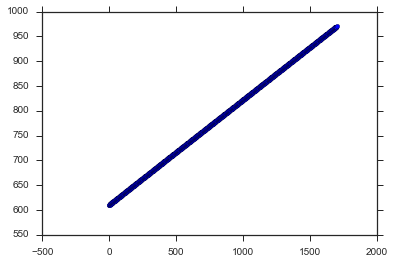

In [106]:
#plt.plot(all_sun_elapsed[0])
print(all_sun_elapsed[0][0])
plt.scatter(np.arange(0,len(all_sun_elapsed[0][8:]),1),all_sun_elapsed[0][8:])

In [ ]:
#get times for when the sun drifts



In [98]:
#do this for the sun
all_sun_elapsed = get_elapsed_time(all_sun_ros_tstamps)



#get the closest times that correspond to start and end times in the reg_t

all_start_times_s = []    
all_end_times_s = []   
for i in range(len(all_start_times)): 
    start_times_trials_s = []
    end_times_trials_s = []    
    for j in range((number_trials)):
        start_times_s = find_nearest(all_sun_elapsed[i], all_start_times[i][j])
        end_times_s = find_nearest(all_sun_elapsed[i], all_end_times[i][j])
        start_times_trials_s.append(start_times_s)
        end_times_trials_s.append(end_times_s)
    all_start_times_s.append(start_times_trials_s)    
    all_end_times_s.append(end_times_trials_s)        

all_start_frames_s = []    
all_end_frames_s = []   
for i in range(len(all_start_times)): 
    start_frames_trials_s = []
    end_frames_trials_s = []    
    for j in range((number_trials)):
        start_frames_s = find_nearest_idx(all_sun_elapsed[i], all_start_times[i][j])
        end_frames_s = find_nearest_idx(all_sun_elapsed[i], all_end_times[i][j])
        start_frames_trials_s.append(start_frames_s)
        end_frames_trials_s.append(end_frames_s)
    all_start_frames_s.append(start_frames_trials_s)    
    all_end_frames_s.append(end_frames_trials_s)     
    
print((all_start_frames_s[8]))
print((all_start_times_s[8]))


[0, 1, 2, 3, 4, 5, 6, 9, 1708]
[0.0, 60.04107093811035, 120.0824294090271, 180.12400650978088, 240.1652991771698, 250.2068772315979, 610.2645289897919, 610.8241589069366, 970.0810384750366]


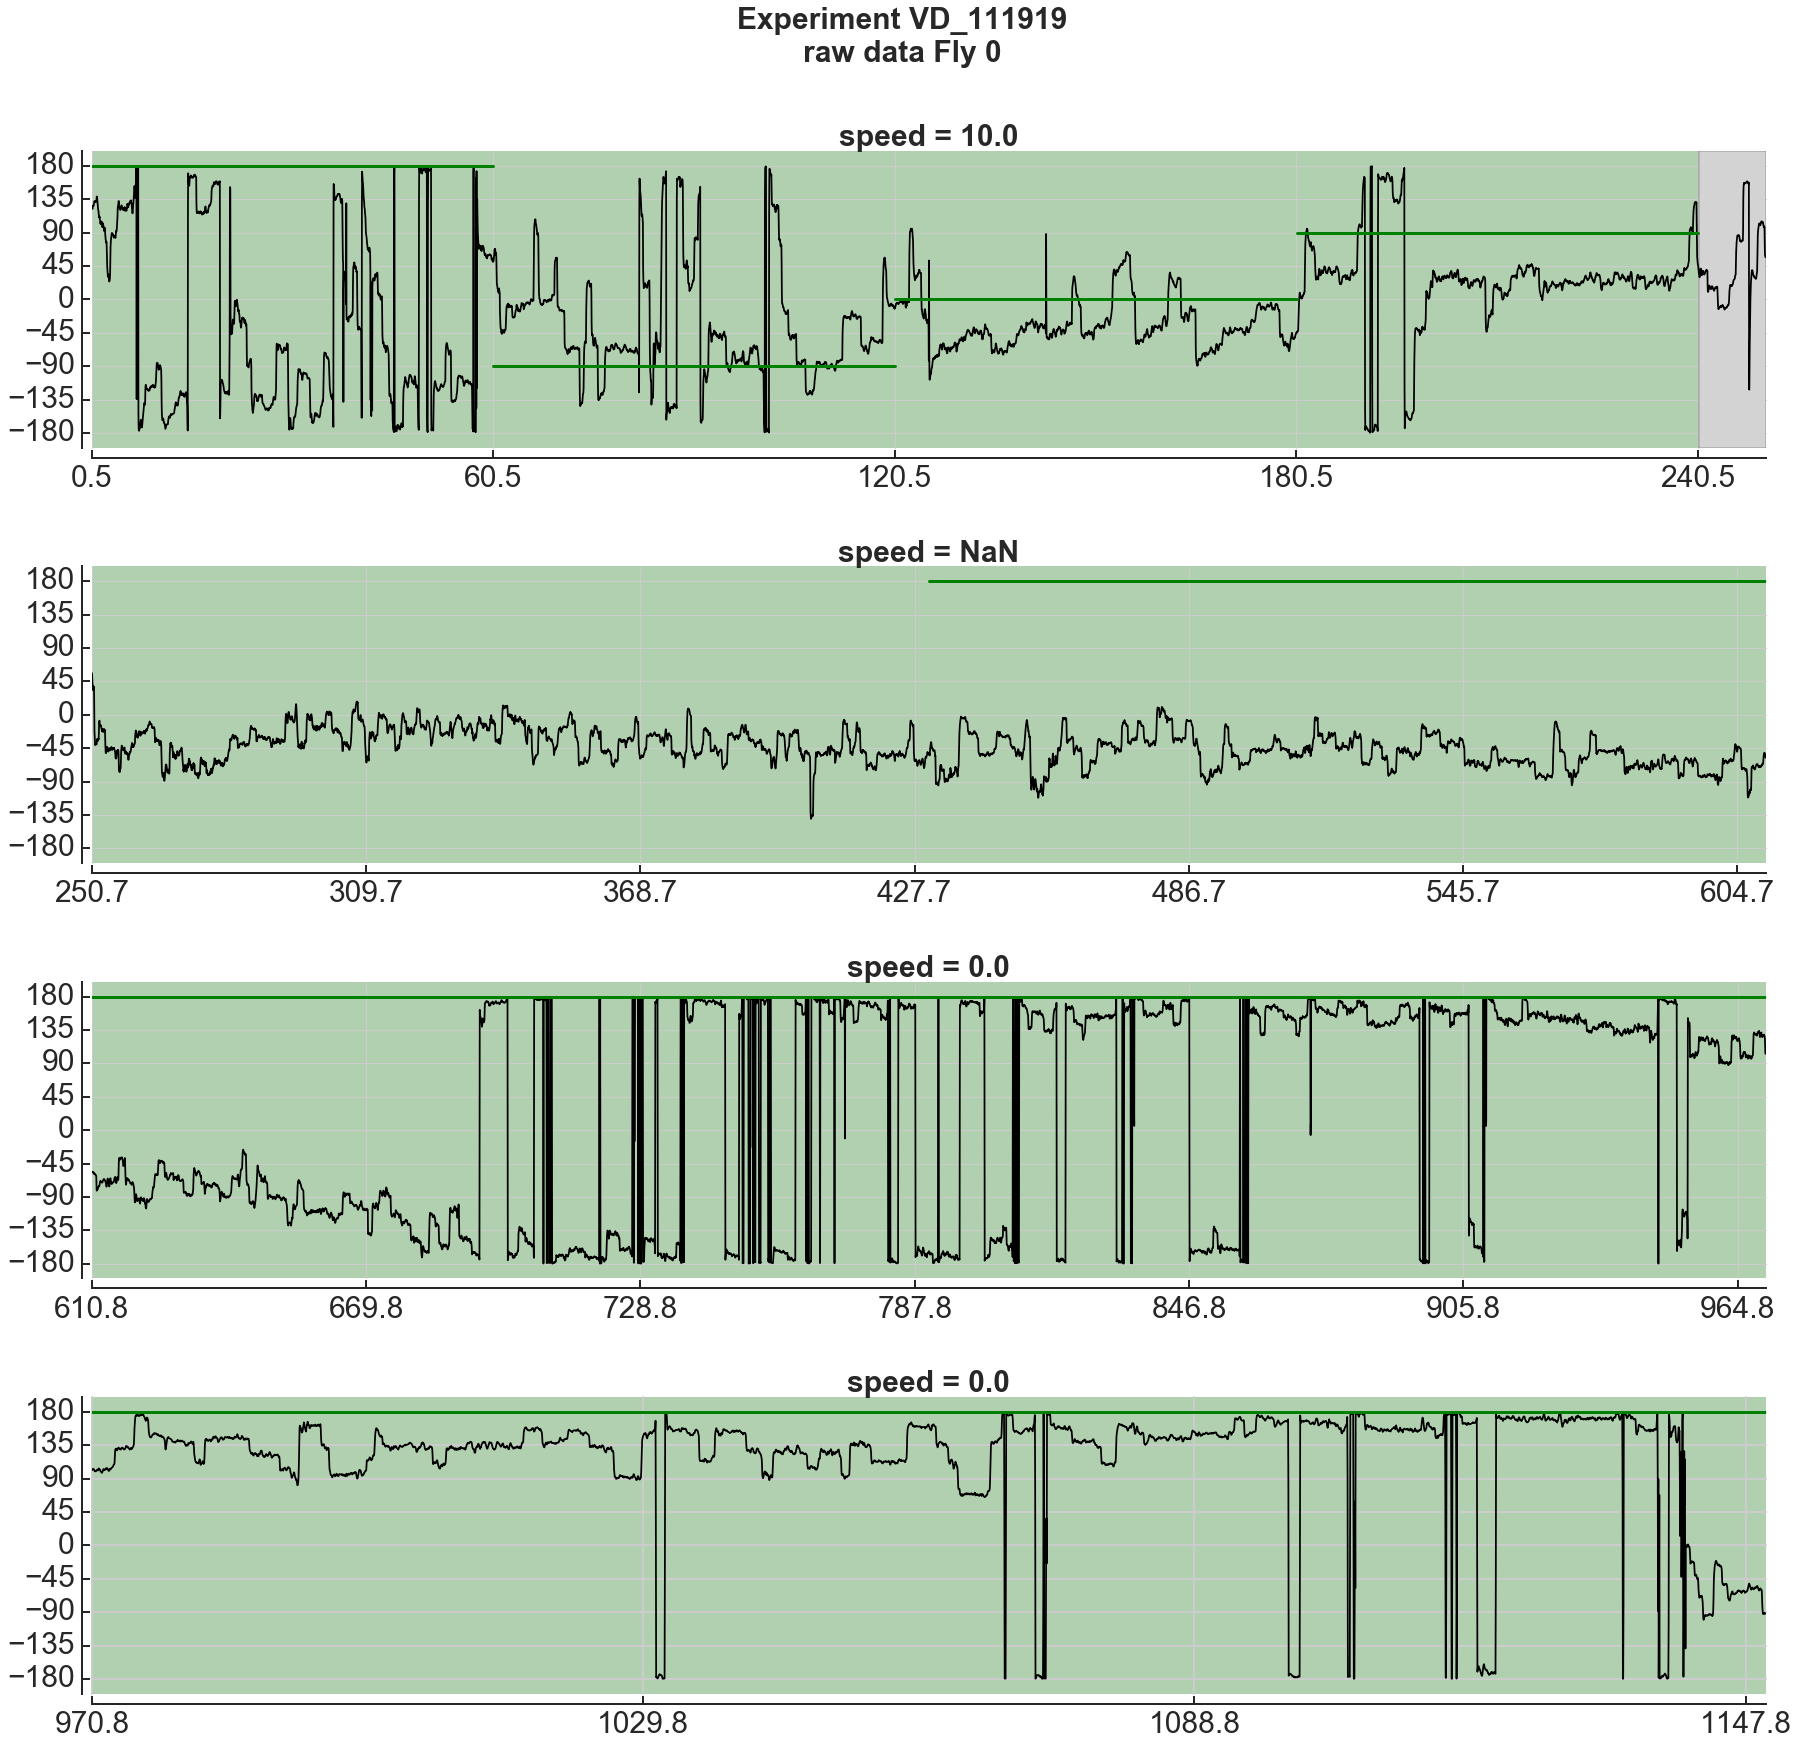

In [65]:
# #plot and save raw data
sns.set_style("ticks")
allangles = all_magnotether_interp_angles

for i in [0]:#range(len(datapaths)):
    # #plot raw normed data
    fig, axs = plt.subplots(figsize=(30, 50), facecolor='w', edgecolor='k')
    #fig.tight_layout()
    fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
    fig.subplots_adjust(top=0.94, hspace = .4, bottom=0.05)
    
    bckclr_labels = ['darkseagreen','darkseagreen', 'darkseagreen','darkseagreen','darkseagreen']
    
    gs = gridspec.GridSpec(8, 2)
    
    ######################################################################################################   
    
##  #control trials (0-3) and dark (4)
    ax1 = plt.subplot(gs[0, :])
    
    a = all_start_frames_m[i][0]
    b = all_end_frames_m[i][0]
    c = all_start_frames_m[i][1]
    d = all_end_frames_m[i][1]
    e = all_start_frames_m[i][2]
    f = all_end_frames_m[i][2]
    g = all_start_frames_m[i][3]
    h = all_end_frames_m[i][3]
    j = all_start_frames_m[i][4]
    k = all_end_frames_m[i][4]
    
    ang_to_plot = allangles[i][a:k] 
    
    ax1.plot(reg_t[a:k],ang_to_plot,color = 'k')
    
    ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][0], all_pat_angles_vd[i][0]), 'green', linewidth= 3)
    ax1.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][1], all_pat_angles_vd[i][1]), 'green', linewidth= 3)
    ax1.plot((reg_t[e],reg_t[f]), (all_pat_angles_vd[i][2], all_pat_angles_vd[i][2]), 'green', linewidth= 3)
    ax1.plot((reg_t[g],reg_t[h]), (all_pat_angles_vd[i][3], all_pat_angles_vd[i][3]), 'green', linewidth= 3)
    ax1.plot((reg_t[j],reg_t[k]), (all_pat_angles_vd[i][4], all_pat_angles_vd[i][4]), 'green', linewidth= 3)
    
    #plot format
    ax1.set_title('speed = '+str(all_speeds_vd[i][3]),fontsize = 30, fontweight='bold')
    ax1.set_ylim([-200, 200])
    ax1.set_xlim([reg_t[a], reg_t[k]])
    ax1.set_xticks(np.arange(reg_t[a], reg_t[h], 60))
    ax1.set_yticks(np.arange(-180, 225,45))
    ax1.yaxis.set_tick_params(labelsize=30)
    ax1.xaxis.set_tick_params(labelsize=30)
    #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
    ax1.axvspan(reg_t[j], reg_t[k], facecolor='lightgray', alpha=1)
    ax1.patch.set_facecolor(bckclr_labels[0])
    ax1.patch.set_alpha(0.7)
    #box, ticks format
    sns.set_style("ticks")
    sns.despine()
    ax1.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.grid(True,linewidth=2)
    
    ######################################################################################################
    
## #trial 5 
    ax2 = plt.subplot(gs[1, :])
    
    a = all_start_frames_m[i][5]
    b = all_end_frames_m[i][5]
    c = all_start_frames_m[i][6]
    d = all_end_frames_m[i][6]    
    
    ang_to_plot = allangles[i][a:d] 
    
    ax2.plot(reg_t[a:d],ang_to_plot,color = 'k')
    ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][5], all_pat_angles_vd[i][5]), 'green', linewidth= 3)
    ax2.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][6], all_pat_angles_vd[i][6]), 'green', linewidth= 3)
    
    #plot format
    ax2.set_title('speed = '+str(all_speeds_vd[i][5]),fontsize = 30, fontweight='bold')
    ax2.set_ylim([-200, 200])
    ax2.set_xlim([reg_t[a], reg_t[d]])
    ax2.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
    ax2.set_yticks(np.arange(-180, 225,45))
    ax2.yaxis.set_tick_params(labelsize=30)
    ax2.xaxis.set_tick_params(labelsize=30)
    #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
    ax2.patch.set_facecolor(bckclr_labels[0])
    ax2.patch.set_alpha(0.7)
    #box, ticks format
    sns.set_style("ticks")
    sns.despine()
    ax2.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.grid(True,linewidth=2) 
    
    ######################################################################################################
    
## #trial 5 and 6 sun only
    ax3 = plt.subplot(gs[2, :])
    
    a = all_start_frames_m[i][7]
    b = all_end_frames_m[i][7]
    
    ang_to_plot = allangles[i][a:b] 
    
    ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
    ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][7], all_pat_angles_vd[i][7]), 'green', linewidth= 3)
    
    #plot format
    ax3.set_title('speed = '+str(all_speeds_vd[i][7]),fontsize = 30, fontweight='bold')
    ax3.set_ylim([-200, 200])
    ax3.set_xlim([reg_t[a], reg_t[b]])
    ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
    ax3.set_yticks(np.arange(-180, 225,45))
    ax3.yaxis.set_tick_params(labelsize=30)
    ax3.xaxis.set_tick_params(labelsize=30)
    #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
    ax3.patch.set_facecolor(bckclr_labels[1])
    ax3.patch.set_alpha(0.7)
    #box, ticks format
    sns.set_style("ticks")
    sns.despine()
    ax3.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    ax3.grid(True,linewidth=2) 
    
    ######################################################################################################
    
##    #trial 7 and 8 sun only
    
    ax4 = plt.subplot(gs[3, :])
    
    a = all_start_frames_m[i][8]
    b = all_end_frames_m[i][8]

    ang_to_plot = allangles[i][a:b] 
    
    ax4.plot(reg_t[a:b],ang_to_plot,color = 'k')
    ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][8], all_pat_angles_vd[i][8]), 'green', linewidth= 3)
    
    #plot format
    ax4.set_title('speed = '+str(all_speeds_vd[i][8]),fontsize = 30, fontweight='bold')
    ax4.set_ylim([-200, 200])
    ax4.set_xlim([reg_t[a], reg_t[b]])
    ax4.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
    ax4.set_yticks(np.arange(-180, 225,45))
    ax4.yaxis.set_tick_params(labelsize=30)
    ax4.xaxis.set_tick_params(labelsize=30)
    #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
    ax4.patch.set_facecolor(bckclr_labels[2])
    ax4.patch.set_alpha(0.7)
    #box, ticks format
    sns.set_style("ticks")
    sns.despine()
    ax4.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False)
    ax4.spines['left'].set_linewidth(2)
    ax4.spines['bottom'].set_linewidth(2)
    ax4.grid(True,linewidth=2)
    
#   ######################################################################################################

#     savefigdir = '/Users/fponce/Documents/vdesert/VD_111919/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [61]:
#vf 
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_vf = copy.deepcopy(all_magnotether_interp_angles)

all_pat_angles_vda = []
for i in all_pat_angles_vd:
    pat_angles_vda = [0 if x=='NaN' else x for x in i]
    all_pat_angles_vda.append(pat_angles_vda)
    
for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles_vda[i][j])

In [62]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [63]:
#sorting trials in terms of speed
all_speeds_vd_sorted = copy.deepcopy(all_speeds_vd)

all_speeds_vd_s = []
for i in range(len(all_speeds_vd_sorted)):
    s = all_speeds_vd_sorted[i][5:]
    all_speeds_vd_s.append(s)

trials_to_be_sorted=[5,6,7,8,9,10,11]

all_idxs_sorted = []
for i in range(len(all_speeds_vd_s)):
    idxs_s = np.argsort(np.array(all_speeds_vd_s[i]))
    idxs_sorted = idxs_s+5
    all_idxs_sorted.append(idxs_sorted)

NameError: name 'zeroo' is not defined

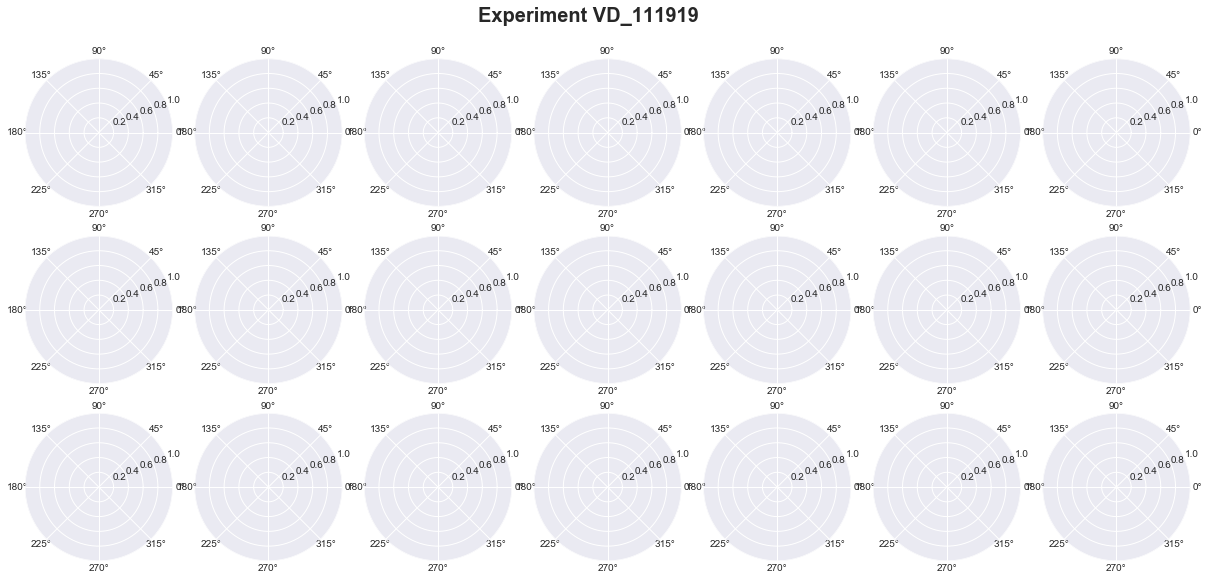

In [64]:
# # circular means plot

fig, axs = plt.subplots(3,7, figsize=(21, 9), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .2, wspace = .1)
fig.suptitle('Experiment '+exp,fontsize = 20, fontweight='bold')

axs = axs.ravel()
p_labels = ['0.0', '1.0', '2.0', '4.0', '8.0', '16.0', '30.0']
bckclr_labels = ['darkseagreen']

for j in range(len(all_idxs_sorted[0])):
    for i in range(len(all_circmeans_vf)):
        if i in zeroo:#pattern and heading diff = 0
            axisorder = [0,1,2,3,4,5,6]
            
            cms = all_circmeans_vf[i][all_idxs_sorted[i][j]]
            cvs = all_circvars_vf[i][all_idxs_sorted[i][j]]
            axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
            axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
            axs[axisorder[j]].grid(False)
            axs[axisorder[j]].set_yticks([])
            axs[axisorder[j]].set_xticks([])
            axs[axisorder[j]].spines['polar'].set_visible(True)
            axs[axisorder[j]].set_rlim(0,1) 
            axs[axisorder[j]].set_title(p_labels[j],fontsize = 15, fontweight='bold')
            axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            
        elif i in ort:#pattern and heading diff = 90
            axisorder = [7,8,9,10,11,12,13]
            
            cms = all_circmeans_vf[i][all_idxs_sorted[i][j]]
            cvs = all_circvars_vf[i][all_idxs_sorted[i][j]]
            axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
            axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
            axs[axisorder[j]].grid(False)
            axs[axisorder[j]].set_yticks([])
            axs[axisorder[j]].set_xticks([])
            axs[axisorder[j]].spines['polar'].set_visible(True)
            axs[axisorder[j]].set_rlim(0,1) 
            axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            
        elif i in fb:#pattern and heading diff = 180
            axisorder = [14,15,16,17,18,19,20]
            
            cms = all_circmeans_vf[i][all_idxs_sorted[i][j]]
            cvs = all_circvars_vf[i][all_idxs_sorted[i][j]]
            axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
            axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
            axs[axisorder[j]].grid(False)
            axs[axisorder[j]].set_yticks([])
            axs[axisorder[j]].set_xticks([])
            axs[axisorder[j]].spines['polar'].set_visible(True)
            axs[axisorder[j]].set_rlim(0,1) 
            #axs[axisorder[j]].yaxis.set_tick_params(labelsize=3, pad=5)
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])

In [ ]:
# # circular means plot

fig, axs = plt.subplots(1,7, figsize=(21, 5), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .2, wspace = .1)
fig.suptitle('Experiment '+exp,fontsize = 20, fontweight='bold')

axs = axs.ravel()
p_labels = ['0.0', '1.0', '2.0', '4.0', '8.0', '16.0', '30.0']
bckclr_labels = ['darkseagreen']

for j in range(len(all_idxs_sorted[0])):
    for i in range(len(all_circmeans_vf)):
#         if i in pattern and heading diff = 0
            axisorder = [0,1,2,3,4,5,6]
            
            cms = all_circmeans_vf[i][all_idxs_sorted[i][j]]
            cvs = all_circvars_vf[i][all_idxs_sorted[i][j]]
            axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
            axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
            axs[axisorder[j]].grid(False)
            axs[axisorder[j]].set_yticks([])
            axs[axisorder[j]].set_xticks([])
            axs[axisorder[j]].spines['polar'].set_visible(True)
            axs[axisorder[j]].set_rlim(0,1) 
            axs[axisorder[j]].set_title(p_labels[j],fontsize = 25, fontweight='bold')
            axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])


In [ ]:
p_labels = ['0.0', '1.0', '2.0', '4.0', '8.0', '16.0', '30.0']
for j in range(len(all_idxs_sorted[0])):
    fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
    for i in range(len(allangles_vf)): 
        p = allangles_vf[i][all_start_frames_m[i][all_idxs_sorted[i][j]]:all_end_frames_m[i][all_idxs_sorted[i][j]]]
        plt.scatter(np.arange(len(p)),p,s=10,color='k',alpha=0.1)
        ax1.plot((0,5400), (0, 0), 'red', linewidth= 3)
        ax1.set_title(p_labels[j],fontsize = 15, fontweight='bold')
        #plot format
        ax1.set_title('speed = '+ p_labels[j]+' pixels/s',fontsize = 20, fontweight='bold')
        ax1.set_ylim([-200, 200])
        ax1.set_xlim([0, (len(p))])
        ax1.set_xticks(np.arange(0, 5401, 1800))
        ax1.set_yticks(np.arange(-180, 225,45))
        ax1.yaxis.set_tick_params(labelsize=20)
        ax1.xaxis.set_tick_params(labelsize=20)
        #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
        #box, ticks format
        sns.set_style("ticks")
        sns.despine()
        ax1.tick_params(direction='in', length=8, width=2)
        sns.despine(offset=10, trim=False);
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.grid(True,linewidth=2)